# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [ ]:
#script for converting *.flac to wav
import os
from os.path import isfile, join
import soundfile as sf

data_directory = 'LibriSpeech'
#print (os.listdir(data_directory))
counter = 0
for subset in os.listdir(data_directory):
    subset_path = join(data_directory, subset)
    if isfile(subset_path) == False:
        for speaker in os.listdir(subset_path):
            speaker_path = join(subset_path, speaker)
            if isfile(speaker_path) == False:
                for chapter in os.listdir(speaker_path):
                    chapter_path = join(speaker_path, chapter);
                    for file in os.listdir(chapter_path):
                        base, ext = os.path.splitext(file)
                        if ext == '.flac':
                            wav_file = base+'.wav'
                            data, samplerate = sf.read(join(chapter_path,file))
                            sf.write (join(chapter_path,wav_file),data, samplerate)
                            
            
            

In [21]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features(2)

There are 103832 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

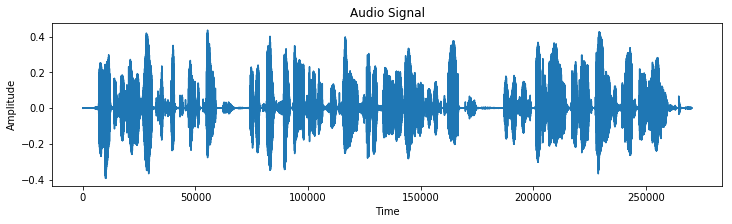

**Shape of Audio Signal** : (270333,)

**Transcript** : he never did any work except to play the pipes and he played so badly that few pennies ever found their way into his pouch it was whispered around that old barney was not very honest

In [22]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

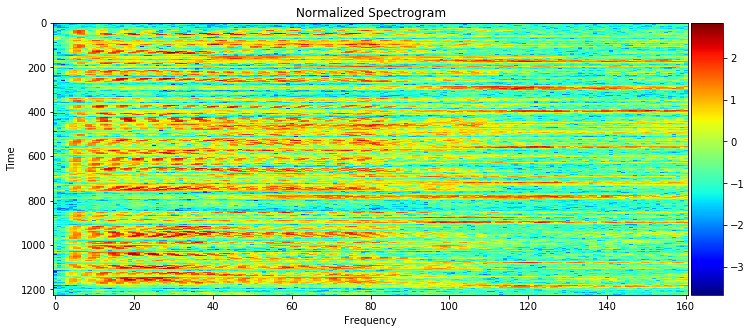

**Shape of Spectrogram** : (1225, 161)

In [23]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

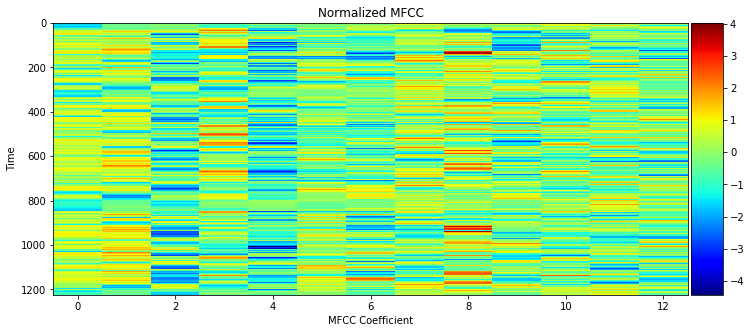

**Shape of MFCC** : (1225, 13)

In [24]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

C:\ProgramData\Anaconda3\envs\nbkeras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [11]:
model_0 = simple_rnn_model(input_dim=13) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [12]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0mfcc.pickle', 
            save_model_path='model_0mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 169s 2s/step - loss: 810.6982 - val_loss: 725.3255
Epoch 2/20
106/106 [==============================] - 170s 2s/step - loss: 750.8593 - val_loss: 726.1611
Epoch 3/20
106/106 [==============================] - 171s 2s/step - loss: 751.0166 - val_loss: 726.3232
Epoch 4/20
106/106 [==============================] - 169s 2s/step - loss: 751.9776 - val_loss: 728.4094
Epoch 5/20
106/106 [==============================] - 168s 2s/step - loss: 752.4276 - val_loss: 720.5551
Epoch 6/20
106/106 [==============================] - 169s 2s/step - loss: 751.4750 - val_loss: 726.2366
Epoch 7/20
106/106 [==============================] - 171s 2s/step - loss: 752.3265 - val_loss: 726.0650
Epoch 8/20
106/106 [==============================] - 176s 2s/step - loss: 751.1899 - val_loss: 729.9564
Epoch 9/20
106/106 [==============================] - 199s 2s/step - loss: 751.0029 - val_loss: 716.1284
Epoch 10/20
106/106 [==============================] - 

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [6]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn (BatchNormalization)      (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


In [10]:
model_1mfcc = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
bn (BatchNormalization)      (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [7]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 175s 2s/step - loss: 313.3852 - val_loss: 251.9315
Epoch 2/20
106/106 [==============================] - 177s 2s/step - loss: 203.9924 - val_loss: 197.6028
Epoch 3/20
106/106 [==============================] - 179s 2s/step - loss: 175.7033 - val_loss: 165.8703
Epoch 4/20
106/106 [==============================] - 185s 2s/step - loss: 160.0397 - val_loss: 156.9879
Epoch 5/20
106/106 [==============================] - 205s 2s/step - loss: 150.5945 - val_loss: 155.0475
Epoch 6/20
106/106 [==============================] - 202s 2s/step - loss: 144.1727 - val_loss: 143.4009
Epoch 7/20
106/106 [==============================] - 210s 2s/step - loss: 139.3822 - val_loss: 143.7242
Epoch 8/20
106/106 [==============================] - 204s 2s/step - loss: 134.7858 - val_loss: 141.0985
Epoch 9/20
106/106 [==============================] - 208s 2s/step - loss: 131.3215 - val_loss: 138.4138
Epoch 10/20
106/106 [==============================] - 

In [11]:
train_model(input_to_softmax=model_1mfcc, 
            pickle_path='model_1mfcc.pickle', 
            save_model_path='model_1mfcc.h5',
            spectrogram=False)

Epoch 1/20
106/106 [==============================] - 171s 2s/step - loss: 284.4959 - val_loss: 263.5732
Epoch 2/20
106/106 [==============================] - 172s 2s/step - loss: 212.1910 - val_loss: 197.8568
Epoch 3/20
106/106 [==============================] - 171s 2s/step - loss: 188.6964 - val_loss: 182.4618
Epoch 4/20
106/106 [==============================] - 171s 2s/step - loss: 174.6329 - val_loss: 170.7661
Epoch 5/20
106/106 [==============================] - 171s 2s/step - loss: 162.0865 - val_loss: 161.8943
Epoch 6/20
106/106 [==============================] - 171s 2s/step - loss: 153.0396 - val_loss: 149.2178
Epoch 7/20
106/106 [==============================] - 171s 2s/step - loss: 146.1992 - val_loss: 148.2374
Epoch 8/20
106/106 [==============================] - 172s 2s/step - loss: 140.9448 - val_loss: 143.0897
Epoch 9/20
106/106 [==============================] - 172s 2s/step - loss: 136.6901 - val_loss: 138.9062
Epoch 10/20
106/106 [==============================] - 

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [4]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\ProgramData\Anaconda3\envs\nbkeras\lib\site-packages\keras\layers\recurrent.py:1028: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [2]:
model_2gru = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200, rnn_type = "GRU")

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_gru (GRU)                (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
___________________________________________________________

In [3]:
model_2lstm = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200, rnn_type = "LSTM")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_lstm (LSTM)              (None, None, 200)         320800    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [5]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 60s 570ms/step - loss: 232.6471 - val_loss: 192.8057
Epoch 2/20
106/106 [==============================] - 47s 441ms/step - loss: 168.3778 - val_loss: 160.3592
Epoch 3/20
106/106 [==============================] - 46s 436ms/step - loss: 145.8432 - val_loss: 144.7986
Epoch 4/20
106/106 [==============================] - 46s 437ms/step - loss: 134.9534 - val_loss: 136.4399
Epoch 5/20
106/106 [==============================] - 46s 436ms/step - loss: 127.1635 - val_loss: 135.8174
Epoch 6/20
106/106 [==============================] - 48s 451ms/step - loss: 121.1509 - val_loss: 130.5963
Epoch 7/20
106/106 [==============================] - 46s 437ms/step - loss: 115.9770 - val_loss: 132.5684
Epoch 8/20
106/106 [==============================] - 46s 434ms/step - loss: 111.1612 - val_loss: 129.0174
Epoch 9/20
106/106 [==============================] - 46s 437ms/step - loss: 108.1509 - val_loss: 131.3256
Epoch 10/20
106/106 [================

In [4]:
train_model(input_to_softmax=model_2gru, 
            pickle_path='model_2gru1.pickle', 
            save_model_path='model_2gru1.h5',
            minibatch_size=20,
            spectrogram=True)

Epoch 1/20
106/106 [==============================] - 96s 902ms/step - loss: 244.9480 - val_loss: 221.5188
Epoch 2/20
106/106 [==============================] - 92s 863ms/step - loss: 186.6704 - val_loss: 161.4403
Epoch 3/20
106/106 [==============================] - 91s 862ms/step - loss: 153.5682 - val_loss: 148.3969
Epoch 4/20
106/106 [==============================] - 92s 865ms/step - loss: 139.4421 - val_loss: 138.6568
Epoch 5/20
106/106 [==============================] - 92s 865ms/step - loss: 129.9341 - val_loss: 134.6786
Epoch 6/20
106/106 [==============================] - 91s 860ms/step - loss: 122.4706 - val_loss: 131.3161
Epoch 7/20
106/106 [==============================] - 90s 852ms/step - loss: 115.8626 - val_loss: 129.2153
Epoch 8/20
106/106 [==============================] - 91s 860ms/step - loss: 110.5362 - val_loss: 131.3354
Epoch 9/20
106/106 [==============================] - 91s 862ms/step - loss: 105.1233 - val_loss: 127.8854
Epoch 10/20
106/106 [================

In [5]:
train_model(input_to_softmax=model_2lstm, 
            pickle_path='model_2lstm.pickle', 
            save_model_path='model_2lstm.h5',
            minibatch_size=20,
            spectrogram=True)

Epoch 1/20
106/106 [==============================] - 88s 826ms/step - loss: 248.3591 - val_loss: 213.5523
Epoch 2/20
106/106 [==============================] - 89s 835ms/step - loss: 197.4995 - val_loss: 171.5045
Epoch 3/20
106/106 [==============================] - 88s 832ms/step - loss: 159.1513 - val_loss: 149.3042
Epoch 4/20
106/106 [==============================] - 87s 822ms/step - loss: 141.1479 - val_loss: 142.1396
Epoch 5/20
106/106 [==============================] - 87s 824ms/step - loss: 130.3665 - val_loss: 132.0510
Epoch 6/20
106/106 [==============================] - 88s 832ms/step - loss: 122.1680 - val_loss: 134.9804
Epoch 7/20
106/106 [==============================] - 87s 821ms/step - loss: 115.2430 - val_loss: 130.5426
Epoch 8/20
106/106 [==============================] - 87s 817ms/step - loss: 109.6812 - val_loss: 126.7528
Epoch 9/20
106/106 [==============================] - 87s 821ms/step - loss: 104.3079 - val_loss: 126.6932
Epoch 10/20
106/106 [================

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [2]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_gru (GRU)                (None, None, 200)         217200    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn_gru1 (GRU)               (None, None, 200)         240600    
_________________________________________________________________
bn-rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [5]:
model_3_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=3) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_gru (CuDNNGRU)           (None, None, 200)         217800    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn_gru1 (CuDNNGRU)          (None, None, 200)         241200    
_________________________________________________________________
bn-rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn_gru2 (CuDNNGRU)          (None, None, 200)         241200    
_________________________________________________________________
bn-rnn2 (BatchNormalization) (None, None, 200)         800       
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 318s 3s/step - loss: 318.4680 - val_loss: 237.3920
Epoch 2/20
106/106 [==============================] - 324s 3s/step - loss: 228.5399 - val_loss: 207.2128
Epoch 3/20
106/106 [==============================] - 325s 3s/step - loss: 205.7203 - val_loss: 187.0898
Epoch 4/20
106/106 [==============================] - 325s 3s/step - loss: 185.3568 - val_loss: 170.9312
Epoch 5/20
106/106 [==============================] - 326s 3s/step - loss: 167.0561 - val_loss: 158.5948
Epoch 6/20
106/106 [==============================] - 324s 3s/step - loss: 156.1977 - val_loss: 152.1498
Epoch 7/20
106/106 [==============================] - 328s 3s/step - loss: 147.9298 - val_loss: 149.4372
Epoch 8/20
106/106 [==============================] - 329s 3s/step - loss: 141.0522 - val_loss: 144.3899
Epoch 9/20
106/106 [==============================] - 327s 3s/step - loss: 135.1512 - val_loss: 142.9841
Epoch 10/20
106/106 [==============================] - 

In [6]:
train_model(input_to_softmax=model_3_3, 
            pickle_path='model_3_3.pickle', 
            save_model_path='model_3_3.h5', 
            spectrogram=True)

Epoch 1/20
106/106 [==============================] - 56s 527ms/step - loss: 302.7496 - val_loss: 230.0278
Epoch 2/20
106/106 [==============================] - 53s 498ms/step - loss: 223.5238 - val_loss: 201.2083
Epoch 3/20
106/106 [==============================] - 54s 507ms/step - loss: 193.1841 - val_loss: 175.5859
Epoch 4/20
106/106 [==============================] - 55s 516ms/step - loss: 168.8443 - val_loss: 162.8661
Epoch 5/20
106/106 [==============================] - 54s 512ms/step - loss: 156.0924 - val_loss: 149.1961
Epoch 6/20
106/106 [==============================] - 55s 516ms/step - loss: 146.6912 - val_loss: 145.2576
Epoch 7/20
106/106 [==============================] - 55s 521ms/step - loss: 138.7805 - val_loss: 141.7108
Epoch 8/20
106/106 [==============================] - 56s 528ms/step - loss: 132.5806 - val_loss: 138.5889
Epoch 9/20
106/106 [==============================] - 55s 518ms/step - loss: 126.7992 - val_loss: 134.7182
Epoch 10/20
106/106 [================

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [2]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 344s 3s/step - loss: 295.1947 - val_loss: 236.1810
Epoch 2/20
106/106 [==============================] - 354s 3s/step - loss: 234.6727 - val_loss: 216.4685
Epoch 3/20
106/106 [==============================] - 374s 4s/step - loss: 214.4574 - val_loss: 195.5398
Epoch 4/20
106/106 [==============================] - 343s 3s/step - loss: 194.7851 - val_loss: 181.4920
Epoch 5/20
106/106 [==============================] - 344s 3s/step - loss: 181.2058 - val_loss: 169.6794
Epoch 6/20
106/106 [==============================] - 349s 3s/step - loss: 170.2962 - val_loss: 162.2663
Epoch 7/20
106/106 [==============================] - 347s 3s/step - loss: 160.0608 - val_loss: 158.0649
Epoch 8/20
106/106 [==============================] - 348s 3s/step - loss: 151.6048 - val_loss: 149.4646
Epoch 9/20
106/106 [==============================] - 346s 3s/step - loss: 144.0467 - val_loss: 148.1037
Epoch 10/20
106/106 [==============================] - 

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [6]:
## (Optional) TODO: Try out some more models!
# train cnn with more data train-360
model_5lstm = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200, rnn_type = "LSTM")

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_lstm (LSTM)              (None, None, 200)         320800    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
___________________________________________________________

In [7]:
# This cell was run and the results are present in results folder. It was rerun by mistake... hence the error in execution
# running this cell takes several hours!
train_model(input_to_softmax=model_5lstm, 
            pickle_path='model_5lstm.pickle', 
            save_model_path='model_5lstm.h5',
            train_json='train_360.json',
            minibatch_size=200,
            spectrogram=True)

Epoch 1/20


InternalError: GPU sync failed

In [2]:
model_6_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=3, rnn_type = 'Cu-GRU') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
CuDNN_gru (CuDNNGRU)         (None, None, 200)         217800    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
CuDNN_gru1 (CuDNNGRU)        (None, None, 200)         241200    
_________________________________________________________________
bn-rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
CuDNN_gru2 (CuDNNGRU)        (None, None, 200)         241200    
_________________________________________________________________
bn-rnn2 (BatchNormalization) (None, None, 200)         800       
__________

In [3]:
train_model(input_to_softmax=model_6_3, 
            pickle_path='model_6_3.pickle', 
            save_model_path='model_6_3.h5',
            train_json='train_360.json',
            minibatch_size=100,
            spectrogram=True)

Epoch 1/20
205/205 [==============================] - 353s 2s/step - loss: 304.9453 - val_loss: 201.5990
Epoch 2/20
205/205 [==============================] - 342s 2s/step - loss: 205.5750 - val_loss: 151.8176
Epoch 3/20
205/205 [==============================] - 341s 2s/step - loss: 170.2565 - val_loss: 131.0678
Epoch 4/20
205/205 [==============================] - 337s 2s/step - loss: 154.4537 - val_loss: 119.3688
Epoch 5/20
205/205 [==============================] - 340s 2s/step - loss: 143.3718 - val_loss: 114.7422
Epoch 6/20
205/205 [==============================] - 337s 2s/step - loss: 134.5747 - val_loss: 106.6021
Epoch 7/20
205/205 [==============================] - 339s 2s/step - loss: 127.5219 - val_loss: 102.6370
Epoch 8/20
205/205 [==============================] - 339s 2s/step - loss: 121.3070 - val_loss: 98.2548
Epoch 9/20
205/205 [==============================] - 338s 2s/step - loss: 115.6684 - val_loss: 93.3804
Epoch 10/20
205/205 [==============================] - 33

In [2]:
model_3_4 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=4, rnn_type = 'Cu-GRU') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
CuDNN_gru (CuDNNGRU)         (None, None, 200)         217800    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
CuDNN_gru1 (CuDNNGRU)        (None, None, 200)         241200    
_________________________________________________________________
bn-rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
__________

In [5]:
train_model(input_to_softmax=model_3_4, 
            pickle_path='model_3_4.pickle', 
            save_model_path='model_3_4.h5',
            train_json='train_460.json',
            minibatch_size=70,
            
            spectrogram=True)

Epoch 1/20
370/370 [==============================] - 511s 1s/step - loss: 321.7632 - val_loss: 396.3468
Epoch 2/20
370/370 [==============================] - 506s 1s/step - loss: 285.3575 - val_loss: 236.8170
Epoch 3/20
370/370 [==============================] - 507s 1s/step - loss: 271.4235 - val_loss: 177.0280
Epoch 4/20
370/370 [==============================] - 509s 1s/step - loss: 258.4085 - val_loss: 178.2681
Epoch 5/20
370/370 [==============================] - 511s 1s/step - loss: 248.7148 - val_loss: 167.6017
Epoch 6/20
370/370 [==============================] - 512s 1s/step - loss: 241.3931 - val_loss: 156.7910
Epoch 7/20
370/370 [==============================] - 512s 1s/step - loss: 235.6325 - val_loss: 140.0672
Epoch 8/20
370/370 [==============================] - 512s 1s/step - loss: 231.2650 - val_loss: 142.4014
Epoch 9/20
370/370 [==============================] - 512s 1s/step - loss: 227.2578 - val_loss: 142.3417
Epoch 10/20
370/370 [==============================] - 

In [11]:
model_4_4 = bidirectional_rnn_model2(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         rnn_type = 'Cu-GRU') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         435600    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 400)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         722400    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 400)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 29)          0         
__________

In [ ]:
from keras.optimizers import SGD
train_model(input_to_softmax=model_4_4, 
            pickle_path='model_4_4.pickle', 
            save_model_path='model_4_4.h5',
            train_json='train_460.json',
            minibatch_size=100,
            
            spectrogram=True
           )

Epoch 1/20


<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

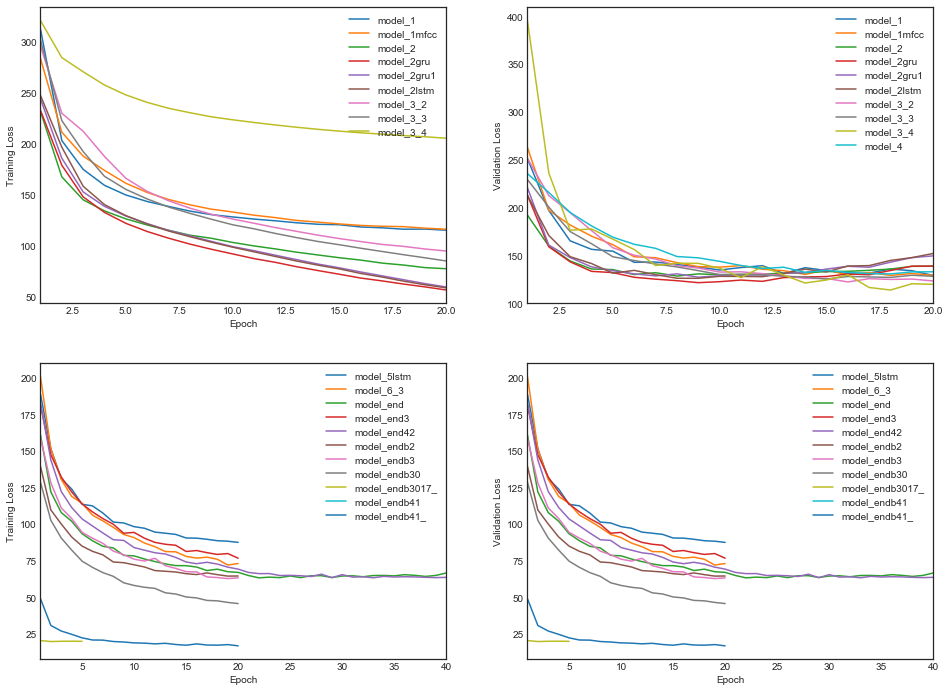

In [5]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,12))

# plot the training loss vs. epoch for early models
ax1 = fig.add_subplot(221)
for i in range(2,11):
        ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
    
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for early models
ax2 = fig.add_subplot(222)
for i in range(2,12): # model 0 loss is around 750 and is not fitting well with the graph
        ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
    
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')

# plot the training loss vs. epoch for later models
ax3 = fig.add_subplot(223)
for i in range(12, len(all_pickles)):
    if i == 14 and i!=18:
        ax3.plot(np.linspace(1, num_epochs[14] + num_epochs[18], num_epochs[14]+ num_epochs[18]), 
            [valid_loss[i][j] if j < num_epochs[i] else valid_loss[18][j-num_epochs[i]] for j in range (num_epochs[14]+ num_epochs[18])], label=model_names[i])
    elif i == 16 and i!=17:
        ax3.plot(np.linspace(1, num_epochs[16] + num_epochs[17], num_epochs[16]+ num_epochs[17]), 
            [valid_loss[i][j] if j < num_epochs[i] else valid_loss[17][j-num_epochs[i]] for j in range (num_epochs[16]+ num_epochs[17])], label=model_names[i])
    elif i!=18 and i!=17:
        ax3.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
ax3.legend()  
ax3.set_xlim([1, 2*max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for later models
ax4 = fig.add_subplot(224)
for i in range(12, len(all_pickles)):
    if i == 14 and i!=18:
        ax4.plot(np.linspace(1, num_epochs[14] + num_epochs[18], num_epochs[14]+ num_epochs[18]), 
            [valid_loss[i][j] if j < num_epochs[i] else valid_loss[18][j-num_epochs[i]] for j in range (num_epochs[14]+ num_epochs[18])], label=model_names[i])
    elif i == 16 and i!=17:
        ax4.plot(np.linspace(1, num_epochs[16] + num_epochs[17], num_epochs[16]+ num_epochs[17]), 
            [valid_loss[i][j] if j < num_epochs[i] else valid_loss[17][j-num_epochs[i]] for j in range (num_epochs[16]+ num_epochs[17])], label=model_names[i])
    elif i!=18 and i!=17:
        ax4.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
    
# clean up the plot
ax4.legend()  
ax4.set_xlim([1, 2*max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')

plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

__Note on graphs:__


Top row graphs are for models 0 - 4 basic models trained on the small dataset. Bottom row graphs are for more advanced models trained on larger dataset. All the models here are trained on a combined 360 +100 hours dataset, except model 5 which is trained on 360 hour dataset only.

__Basic Models__

Model 0: - Simple 1 layer rnn model. Two variants were trained one using the spectogram as input and another mfcc features

Model 1: - Two layer model that adds time distributed layer on top of Rnn layer

Model 2: - The cnn layer is added before model 1 to extract features from spectogram input

        baseline - SimpleRnn cells
        gru1 - standard gru cell activation
        gru - using 'relu' instead of 'tanh' activation
        lstm - lstm cell 
        
Model 3: - Instead of adding cnn several Rnn layers are used

Model 4: - Bidirectional Rnn



__Experimental Models__

model 5: is similar to model2 lstm, but trained on larger 360 hour dataset

model 6_3: 3 layer gru rnn trained on 460 hours of transcribed speech

model end: 1 layer cnn + 4 layer gru rnn with 0 dropout

model_end3: 1 layer cnn + 3 layer gru rnn with .2 dropout

model_end42: 1 layer cnn + 4 layer gru rnn with .2 dropout




__Results:__


__Basic models__

model 0:

It is clear that the default model0 that uses just one RNN layer is too simple to deal with the data complexity and both its training and validation loss are very high. 

model1:

Addition of the Time distributed layer on top of RNN improves the results drastically. For the amount of data that is tested (~2000 labelled examples) it reaches similar results to more complex models, without much overfitting. So it might be chosen if the amount of data does not increase.

model2:

The addition of CNN layer to extract features from the spectogram data clearly improves the model capacity, however at around 8 epochs the validation loss reaches it's minimum and further training leads to decreased performance and overfitting. The variant that uses non-standard gru cell with 'relu' activation outperforms other models of this type slightly. While standard GRU and LSTM perform about the same and slightly better than SimpleRnn

model3:

Increasing the depth of the model by adding several rnn layers also has positive effect on the model capcity and its validation loss. The model with 2 gru layers performs better than model with 1 and model with 3 gru layers performs best.

model4:

Bidirectional layer is performing better than single gru rnn layer, however it seems that stacking two regular rnn layers on top of each other outperforms a bidirectional layer so regular stacking works better for the same number of parameters

Experimental models:

model5:

This model is exactly the same as model 2 lstm. The only difference is that it is trained on more data and reduces validation loss by about 50%

model6_3:

This model is trained on even larger dataset than model 5 and has exactly the same architecture as model_3_3 with 3 rnn layers stacked on top of each other. Clearly training on more data has potential for improving validation loss.

model_end:

This is a variant of the final architecture 1 Cnn layer for extracting features before a number of rnn layers. This variant has 4 rnn layers and 0 dropout. It produces the lowest validation loss of all the models tested, along with model_end42. However unlike model_end42 it is less stable and can suffer from overfitting when overtrained. It reached its lowest validation loss at epoch 24 and then the results started to decrease again.

model_end3:

This is a variant of 1 cnn layer 3 rnn layers with .2 dropout. It did not show as much promise as model_end42, so it was run only for 20 epochs.

model_end42:

This is the best model. By adding .2 dropout to model_end, the training  process is stabilized. The training loss is much higher with dropout present, than in model withouth dropout, but it practically stops decresing indicating that no overfitting occurs. The model reaches what seems to be very close to the optimal performance at epoch 40. The final loss of 64.0 is very. It might be possible to decrease loss by a couple of points by further training, but judging from the graph the model seems to be very close to its optimum performance. (See more in answer to question 2)



<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [2]:
# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers = 4,
                        units=200,
                        rnn_type = 'Cu-GRU'
                        )

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
CuDNN_gru (CuDNNGRU)         (None, None, 200)         241200    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 200)         800       
___________________________________________________________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            train_json = 'train_460.json',
            minibatch_size = 150,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
172/172 [==============================] - 435s 3s/step - loss: 245.2422 - val_loss: 161.6294
Epoch 2/20
172/172 [==============================] - 444s 3s/step - loss: 165.1698 - val_loss: 122.4861
Epoch 3/20
172/172 [==============================] - 436s 3s/step - loss: 140.4409 - val_loss: 108.3423
Epoch 4/20
172/172 [==============================] - 375s 2s/step - loss: 126.9015 - val_loss: 102.4166
Epoch 5/20
172/172 [==============================] - 363s 2s/step - loss: 117.7368 - val_loss: 93.8839
Epoch 6/20
172/172 [==============================] - 355s 2s/step - loss: 110.7470 - val_loss: 89.0502
Epoch 7/20
172/172 [==============================] - 355s 2s/step - loss: 105.2004 - val_loss: 85.2553
Epoch 8/20
172/172 [==============================] - 356s 2s/step - loss: 100.6019 - val_loss: 84.1649
Epoch 9/20
172/172 [==============================] - 353s 2s/step - loss: 96.5972 - val_loss: 79.0566
Epoch 10/20
172/172 [==============================] - 353s 2

In [6]:
from keras.optimizers import SGD
train_model(input_to_softmax=model_end, 
            pickle_path='model_end_.pickle', 
            save_model_path='model_end_.h5', 
            train_json = 'train_460.json',
            minibatch_size = 150,
            spectrogram=True,
           optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5))

Epoch 1/20
172/172 [==============================] - 386s 2s/step - loss: 65.6835 - val_loss: 65.2768
Epoch 2/20
172/172 [==============================] - 374s 2s/step - loss: 63.1421 - val_loss: 63.6944
Epoch 3/20
172/172 [==============================] - 370s 2s/step - loss: 62.3408 - val_loss: 64.1800
Epoch 4/20
172/172 [==============================] - 386s 2s/step - loss: 61.8530 - val_loss: 63.8516
Epoch 5/20
172/172 [==============================] - 416s 2s/step - loss: 61.3391 - val_loss: 65.0039
Epoch 6/20
172/172 [==============================] - 476s 3s/step - loss: 60.9520 - val_loss: 63.8538
Epoch 7/20
172/172 [==============================] - 424s 2s/step - loss: 60.5299 - val_loss: 65.1240
Epoch 8/20
172/172 [==============================] - 416s 2s/step - loss: 60.1897 - val_loss: 65.1775
Epoch 9/20
172/172 [==============================] - 402s 2s/step - loss: 59.8087 - val_loss: 63.9364
Epoch 10/20
172/172 [==============================] - 402s 2s/step - los

In [2]:
model_end3 = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers = 3,
                        units=200,
                        rnn_type = 'Cu-GRU',
                        dropout =.2)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
CuDNN_gru (CuDNNGRU)         (None, None, 200)         241200    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 200)         800       
___________________________________________________________

In [3]:
train_model(input_to_softmax=model_end3, 
            pickle_path='model_end3.pickle', 
            save_model_path='model_end3.h5', 
            train_json = 'train_460.json',
            minibatch_size = 150,
            spectrogram=True)

Epoch 1/20
172/172 [==============================] - 473s 3s/step - loss: 279.5341 - val_loss: 182.0722
Epoch 2/20
172/172 [==============================] - 447s 3s/step - loss: 232.8010 - val_loss: 147.9332
Epoch 3/20
172/172 [==============================] - 433s 3s/step - loss: 211.6460 - val_loss: 132.6917
Epoch 4/20
172/172 [==============================] - 427s 2s/step - loss: 198.9384 - val_loss: 122.4759
Epoch 5/20
172/172 [==============================] - 425s 2s/step - loss: 189.4652 - val_loss: 114.2220
Epoch 6/20
172/172 [==============================] - 424s 2s/step - loss: 182.2151 - val_loss: 108.8174
Epoch 7/20
172/172 [==============================] - 421s 2s/step - loss: 176.4388 - val_loss: 104.2157
Epoch 8/20
172/172 [==============================] - 421s 2s/step - loss: 171.3781 - val_loss: 100.3927
Epoch 9/20
172/172 [==============================] - 430s 2s/step - loss: 167.0972 - val_loss: 94.2308
Epoch 10/20
172/172 [==============================] - 4

In [9]:
model_end42 = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers = 4,
                        units=200,
                        rnn_type = 'Cu-GRU',
                        dropout =.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
CuDNN_gru (CuDNNGRU)         (None, None, 200)         241200    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 200)         0         
__________

In [3]:
train_model(input_to_softmax=model_end42, 
            pickle_path='model_end42.pickle', 
            save_model_path='model_end42.h5', 
            train_json = 'train_460.json',
            minibatch_size = 100,
            spectrogram=True)

Epoch 1/20
259/259 [==============================] - 401s 2s/step - loss: 274.7286 - val_loss: 183.3314
Epoch 2/20
259/259 [==============================] - 358s 1s/step - loss: 225.4952 - val_loss: 144.3581
Epoch 3/20
259/259 [==============================] - 355s 1s/step - loss: 201.7252 - val_loss: 122.7463
Epoch 4/20
259/259 [==============================] - 357s 1s/step - loss: 188.0775 - val_loss: 111.8437
Epoch 5/20
259/259 [==============================] - 388s 1s/step - loss: 178.5778 - val_loss: 103.9976
Epoch 6/20
259/259 [==============================] - 369s 1s/step - loss: 171.2719 - val_loss: 99.1918
Epoch 7/20
259/259 [==============================] - 352s 1s/step - loss: 165.5466 - val_loss: 94.3808
Epoch 8/20
259/259 [==============================] - 354s 1s/step - loss: 160.7154 - val_loss: 89.7845
Epoch 9/20
259/259 [==============================] - 360s 1s/step - loss: 156.5643 - val_loss: 89.3068
Epoch 10/20
259/259 [==============================] - 368s

In [6]:
model_end42.load_weights('results/' +'model_end42.h5')

In [7]:
from keras.optimizers import SGD
train_model(input_to_softmax=model_end42, 
            pickle_path='model_end42_.pickle', 
            save_model_path='model_end42_.h5', 
            train_json = 'train_460.json',
            minibatch_size = 100,
            spectrogram=True,
           optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5))

Epoch 1/20
259/259 [==============================] - 401s 2s/step - loss: 126.1971 - val_loss: 67.3821
Epoch 2/20
259/259 [==============================] - 383s 1s/step - loss: 124.1216 - val_loss: 66.5672
Epoch 3/20
259/259 [==============================] - 380s 1s/step - loss: 123.5773 - val_loss: 66.6168
Epoch 4/20
259/259 [==============================] - 368s 1s/step - loss: 123.1021 - val_loss: 65.2848
Epoch 5/20
259/259 [==============================] - 363s 1s/step - loss: 122.6130 - val_loss: 65.4033
Epoch 6/20
259/259 [==============================] - 360s 1s/step - loss: 122.5090 - val_loss: 65.1262
Epoch 7/20
259/259 [==============================] - 358s 1s/step - loss: 122.1772 - val_loss: 64.6121
Epoch 8/20
259/259 [==============================] - 359s 1s/step - loss: 121.9001 - val_loss: 66.1884
Epoch 9/20
259/259 [==============================] - 359s 1s/step - loss: 121.5819 - val_loss: 63.8006
Epoch 10/20
259/259 [==============================] - 362s 1s/s

In [2]:
model_endb2 = final_model1(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers = 2,
                        units=200,
                        rnn_type = 'Cu-GRU',
                        dropout =0)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 400)         1600      
___________________________________________________________

In [3]:
train_model(input_to_softmax=model_endb2, 
            pickle_path='model_endb2.pickle', 
            save_model_path='model_endb2.h5', 
            train_json = 'train_460.json',
            minibatch_size = 100,
            spectrogram=True
           )

Epoch 1/20
259/259 [==============================] - 415s 2s/step - loss: 225.6442 - val_loss: 140.0644
Epoch 2/20
259/259 [==============================] - 374s 1s/step - loss: 149.8854 - val_loss: 110.1407
Epoch 3/20
259/259 [==============================] - 372s 1s/step - loss: 128.4543 - val_loss: 100.5185
Epoch 4/20
259/259 [==============================] - 361s 1s/step - loss: 116.3807 - val_loss: 91.6663
Epoch 5/20
259/259 [==============================] - 356s 1s/step - loss: 107.7970 - val_loss: 85.4109
Epoch 6/20
259/259 [==============================] - 348s 1s/step - loss: 100.9936 - val_loss: 81.8393
Epoch 7/20
259/259 [==============================] - 353s 1s/step - loss: 95.3679 - val_loss: 79.4082
Epoch 8/20
259/259 [==============================] - 410s 2s/step - loss: 90.5722 - val_loss: 74.5422
Epoch 9/20
259/259 [==============================] - 398s 2s/step - loss: 86.4153 - val_loss: 74.0608
Epoch 10/20
259/259 [==============================] - 391s 2s/s

In [71]:
model_endb3 = final_model1(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers = 3,
                        units=200,
                        rnn_type = 'Cu-GRU',
                        dropout =.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 400)         1600      
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 400)         0         
__________

In [73]:
train_model(input_to_softmax=model_endb3, 
            pickle_path='model_endb3.pickle', 
            save_model_path='model_endb3.h5', 
            train_json = 'train_460.json',
            minibatch_size = 70,
            spectrogram=True
           )

Epoch 1/20
370/370 [==============================] - 872s 2s/step - loss: 264.3736 - val_loss: 159.4301
Epoch 2/20
370/370 [==============================] - 848s 2s/step - loss: 209.7883 - val_loss: 128.6672
Epoch 3/20
370/370 [==============================] - 850s 2s/step - loss: 188.1479 - val_loss: 111.5183
Epoch 4/20
370/370 [==============================] - 850s 2s/step - loss: 174.7001 - val_loss: 104.3072
Epoch 5/20
370/370 [==============================] - 851s 2s/step - loss: 164.4357 - val_loss: 94.8700
Epoch 6/20
370/370 [==============================] - 845s 2s/step - loss: 156.5944 - val_loss: 90.8398
Epoch 7/20
370/370 [==============================] - 852s 2s/step - loss: 150.1936 - val_loss: 87.2773
Epoch 8/20
370/370 [==============================] - 848s 2s/step - loss: 145.0011 - val_loss: 81.9952
Epoch 9/20
370/370 [==============================] - 826s 2s/step - loss: 140.3665 - val_loss: 79.5034
Epoch 10/20
370/370 [==============================] - 822s 

In [3]:
model_endb3017 = final_model1(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers = 3,
                        units=200,
                        rnn_type = 'Cu-GRU',
                        dropout =0)


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 400)         1600      
___________________________________________________________

In [5]:
model_endb3017.load_weights('results/model_endb3017.h5')

In [ ]:
train_model(input_to_softmax=model_endb3017, 
            pickle_path='model_endb3017.pickle', 
            save_model_path='model_endb3017.h5', 
            train_json = 'train_960.json',
            minibatch_size = 100,
            spectrogram=True
           )

Epoch 1/20
2806/2806 [==============================] - 8672s 3s/step - loss: 247.1523 - val_loss: 88.1371
Epoch 2/20
2806/2806 [==============================] - 8617s 3s/step - loss: 139.8736 - val_loss: 53.2014
Epoch 3/20
2806/2806 [==============================] - 8670s 3s/step - loss: 105.4689 - val_loss: 43.5746
Epoch 4/20
2806/2806 [==============================] - 8497s 3s/step - loss: 88.9577 - val_loss: 37.7609
Epoch 5/20
2806/2806 [==============================] - 8330s 3s/step - loss: 78.6618 - val_loss: 34.1282
Epoch 6/20
2806/2806 [==============================] - 8050s 3s/step - loss: 71.5445 - val_loss: 30.7608
Epoch 7/20
2806/2806 [==============================] - 8022s 3s/step - loss: 66.4294 - val_loss: 30.0222
Epoch 8/20
2719/2806 [============================>.] - ETA: 4:06 - loss: 62.6227

In [163]:
from keras.optimizers import SGD
train_model(input_to_softmax=model_endb3017, 
            pickle_path='model_endb3017_.pickle', 
            save_model_path='model_endb3017_.h5', 
            train_json = 'train_960.json',
            minibatch_size = 100,
            spectrogram=True,
            optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            epochs = 5
           )

Epoch 1/5
2806/2806 [==============================] - 8510s 3s/step - loss: 45.1630 - val_loss: 20.7995
Epoch 2/5
2806/2806 [==============================] - 8472s 3s/step - loss: 40.0440 - val_loss: 20.1108
Epoch 3/5
2806/2806 [==============================] - 8528s 3s/step - loss: 39.2983 - val_loss: 20.2981
Epoch 4/5
2806/2806 [==============================] - 8540s 3s/step - loss: 38.8631 - val_loss: 20.3475
Epoch 5/5
2806/2806 [==============================] - 8087s 3s/step - loss: 38.5175 - val_loss: 20.2650


In [2]:
model_endb41 = final_model1(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=300,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers = 4,
                        units=300,
                        rnn_type = 'Cu-GRU',
                        dropout =.1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 300)         531600    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 300)         1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 600)         1083600   
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 600)         2400      
___________________________________________________________

In [3]:
model_endb41.load_weights('results/model_endb41.h5')

In [4]:
train_model(input_to_softmax=model_endb41, 
            pickle_path='model_endb41_.pickle', 
            save_model_path='model_endb41_.h5', 
            train_json = 'train_all.json',
            minibatch_size = 50,
            spectrogram=True
           )

Epoch 1/20
9523/9523 [==============================] - 10344s 1s/step - loss: 135.1617 - val_loss: 49.4882
Epoch 2/20
9523/9523 [==============================] - 11075s 1s/step - loss: 97.6594 - val_loss: 31.1146
Epoch 3/20
9523/9523 [==============================] - 11054s 1s/step - loss: 82.3899 - val_loss: 27.3116
Epoch 4/20
9523/9523 [==============================] - 11013s 1s/step - loss: 75.1949 - val_loss: 25.0574
Epoch 5/20
9523/9523 [==============================] - 11013s 1s/step - loss: 70.8081 - val_loss: 22.6535
Epoch 6/20
9523/9523 [==============================] - 11081s 1s/step - loss: 67.7099 - val_loss: 21.1782
Epoch 7/20
9523/9523 [==============================] - 11051s 1s/step - loss: 65.4344 - val_loss: 21.0807
Epoch 8/20
9523/9523 [==============================] - 11117s 1s/step - loss: 63.6296 - val_loss: 20.1377
Epoch 9/20
9523/9523 [==============================] - 11114s 1s/step - loss: 62.1979 - val_loss: 19.7920
Epoch 10/20
9523/9523 [=============

## __Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__
For the final architecture I decided to choose the architecture with CNN layer that would preprocess spectrogram input and prepare the features for the input into several layers of RNN that act similar to phonetic and language models. The preliminary results indicated that simply stacking the RNN layers on top of each other was slightly more effective than the bidirectional RNN, so that is the architecture I chose. I experimented with the amount of RNN layers and dropout and finally the architecture with 1 CNN layer and 4 rnn layers and .2 dropout seemed to produce the best and most stable results. One final note. I used the combined 100 hour and 360 hour dataset for training the model. The clear trend from the experiments was that the more the amount of data I have for training the better the results are irrespective of the exact architecture used. Also with the increased amount of data the bigger models tended to become more powerful and overfit less.

Future work:
I also worked on a separate language model for which I downloaded 3gb worth of text files from project gutenberg. I preprocessed the files by removing them from archives and removing irrelevant header and footer texts, and then removing all the characters except letters and space and converting to lowercase. Due to the time constraints I could not finish model training or incorporate the language model into ASR. I hope to do it in the near future

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [7]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    #filepath='results/'+save_model_path
    input_to_softmax.load_weights('results/'+model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    print (prediction)
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)
    
    return prediction, pred_ints

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [14]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2, rnn_type = 'Cu-GRU') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
CuDNN_gru (CuDNNGRU)         (None, None, 200)         217800    
_________________________________________________________________
bn-rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
CuDNN_gru1 (CuDNNGRU)        (None, None, 200)         241200    
_________________________________________________________________
bn-rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [17]:
pred, pred_ints = get_predictions(index=4, 
                partition='train',
                input_to_softmax=model_endb41,
                model_path='model_endb41_.h5')

[[[6.7801828e-08 4.1187000e-06 5.5710691e-01 ... 4.6923878e-07
   3.2314976e-08 4.4243926e-01]
  [3.3205734e-07 5.9074907e-08 9.9234581e-01 ... 3.6959619e-07
   2.3871971e-08 7.5302809e-03]
  [7.4601729e-08 1.9635969e-08 2.1526691e-01 ... 3.8757108e-07
   4.0202854e-09 7.7415204e-01]
  ...
  [1.0830570e-09 1.4770526e-05 1.4203353e-08 ... 1.3846092e-09
   2.2179854e-10 9.9998498e-01]
  [4.3715240e-09 4.7560647e-05 2.0793294e-08 ... 3.0289675e-09
   2.3362060e-10 9.9995196e-01]
  [1.2620976e-08 4.6851830e-05 2.9347223e-08 ... 7.7387163e-09
   1.7211273e-10 9.9995291e-01]]]
--------------------------------------------------------------------------------
True transcription:

and they lived all alone in a little hut away at the end of the village street for tom's mother had died when he was a baby you may not suppose that tom was a very good boy since he had such a queer father but neither was he very bad
--------------------------------------------------------------------------------
Predi

In [162]:
chars = ' abcdefghijklmnopqrstuvwxyz?'
print (chars[(np.argmax((pred[0,175, :])))-1])
print (pred[0,178, :])

?
[1.1101737e-08 7.6039476e-05 7.7999641e-07 8.7884304e-09 3.1034686e-04
 2.3382817e-08 5.0633351e-09 4.2659874e-08 1.6521599e-06 1.0369005e-07
 1.7934143e-08 4.9133926e-11 6.3533059e-07 1.5034164e-10 1.4983396e-08
 7.3992076e-08 5.4179230e-07 3.6877239e-08 3.7707335e-09 1.8624130e-09
 5.9312377e-08 2.5619920e-06 8.0402662e-09 1.2689141e-10 2.9728044e-08
 4.8777933e-09 1.0873318e-11 5.7317818e-12 9.9960703e-01]


## Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [172]:
get_predictions(index=100, 
                partition='validation',
                input_to_softmax=model_endb3017, 
                model_path='model_endb3017_.h5')

[[[6.0855292e-08 7.9418741e-15 2.4978274e-06 ... 8.6986773e-09
   1.6485296e-11 9.9999428e-01]
  [3.8613535e-08 3.9748132e-14 2.1902423e-07 ... 1.8207174e-08
   1.0377390e-10 9.9999535e-01]
  [2.0383606e-08 8.0431254e-14 7.2734245e-08 ... 9.9335882e-09
   7.1889508e-11 9.9999368e-01]
  ...
  [2.3995970e-09 2.8335464e-07 5.4929306e-09 ... 9.9550515e-12
   1.8348907e-12 9.9999821e-01]
  [3.0053671e-09 1.2344972e-05 1.4500894e-08 ... 8.8421683e-12
   1.9390390e-12 9.9998629e-01]
  [3.9739895e-08 5.8593499e-03 9.6965425e-07 ... 3.8843948e-10
   5.7670448e-11 9.9413365e-01]]]
--------------------------------------------------------------------------------
True transcription:

harangue the tiresome product of a tireless tongue
--------------------------------------------------------------------------------
Predicted transcription:

her rang the tiresome prodect of atireless tonue
--------------------------------------------------------------------------------


(array([[[6.0855292e-08, 7.9418741e-15, 2.4978274e-06, ...,
          8.6986773e-09, 1.6485296e-11, 9.9999428e-01],
         [3.8613535e-08, 3.9748132e-14, 2.1902423e-07, ...,
          1.8207174e-08, 1.0377390e-10, 9.9999535e-01],
         [2.0383606e-08, 8.0431254e-14, 7.2734245e-08, ...,
          9.9335882e-09, 7.1889508e-11, 9.9999368e-01],
         ...,
         [2.3995970e-09, 2.8335464e-07, 5.4929306e-09, ...,
          9.9550515e-12, 1.8348907e-12, 9.9999821e-01],
         [3.0053671e-09, 1.2344972e-05, 1.4500894e-08, ...,
          8.8421683e-12, 1.9390390e-12, 9.9998629e-01],
         [3.9739895e-08, 5.8593499e-03, 9.6965425e-07, ...,
          3.8843948e-10, 5.7670448e-11, 9.9413365e-01]]], dtype=float32),
 [10,
  7,
  20,
  2,
  20,
  3,
  16,
  9,
  2,
  22,
  10,
  7,
  2,
  22,
  11,
  20,
  7,
  21,
  17,
  15,
  7,
  2,
  18,
  20,
  17,
  6,
  7,
  5,
  22,
  2,
  17,
  8,
  2,
  3,
  22,
  11,
  20,
  7,
  14,
  7,
  21,
  21,
  2,
  22,
  17,
  16,
  23,
  7])

In [ ]:
# The results are not perfect, but not too bad

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

C:\ProgramData\Anaconda3\envs\nbkeras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from keras.layers import Input, Conv1D
input_dim = 161
filters =200
kernel_size = 11
conv_stride =2
conv_border_mode = 'valid'
input_data = Input(name='the_input', shape=(None, input_dim))
    # Add convolutional layer
conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)

In [8]:
input_data.shape

TensorShape([Dimension(None), Dimension(None), Dimension(161)])